# 6. Sparse Kernel Machines

### *Table of Contents*

* 7.1 [Maximum Margin Classifiers](#7.1-Maximum-Margin-Classifiers)
    * 7.1.1 [Overlapping class distributions](#7.1.1-Overlapping-class-distributions)

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from prml.kernel import SupportVectorClassifier, RBF

# Set random seed to make deterministic
np.random.seed(0)

# Ignore zero divisions and computation involving NaN values.
np.seterr(divide="ignore", invalid="ignore")

# Enable higher resolution plots
%config InlineBackend.figure_format = 'retina'

# Enable autoreload all modules before executing code
%reload_ext autoreload
%autoreload 2

One significant limitation of many kernel-based methods (see [Chapter 6](ch6_kernel_methods.ipynb)) is that the kernel function $k(\mathbf{x}_n, \mathbf{x}_m)$ must be evaluated for all possible pairs $\mathbf{x}_n$ and $\mathbf{x}_m$ of training data points. This can be computationally infeasible during training (does not scale to large datasets) and also leads to excessive computation overhead when making predictions for new data points.

On the other hand, there are kernel-based algorithms that yield *sparse* solutions (maintain a subset of training data points), so that predictions depend only on the kernel fuction evaluated at the subset of these training data points. We shall look into *support vector machine* (SVM), which are easy to train using convex optimization, but does not provide posterior probabilities. An alternative sparse kernel technique, known as *relevance vector machine* (RVM), is based on Bayesian formulation and provides posterior probabilistic outputs. Additionally, RVM has much sparser solutions than SVM, but it is slower to optimize.

## 7.1 Maximum Margin Classifiers

Consider the classification problem using linear models of the form,

$$
y(\mathbf{x}) = \mathbf{w}^T\boldsymbol\phi(\mathbf{x}) + b
$$

The training data set comprises $N$ input vectors $\mathbf{x}_1,\dots,\mathbf{x}_N$ and corresponding target values $t_1,\dots,t_N$, where $t_n\in\{−1, 1\}$.

> We assume for the moment that the training dataset is linearly separable in feature space defined by $\boldsymbol\phi$, so that there exists at least one choice of parameters such $y(\mathbf{x}_n)>0$ for points having $t_n=+1$ and $y(\mathbf{x}_n)<0$ for points having $t_n=−1$. In general, so that $t_ny(\mathbf{x}_n) > 0$ for all training data points.

The support vector machine approaches this problem through the concept of the margin, which is defined to be the smallest distance between the decision boundary and any of the samples. In support vector machine the decision boundary is chosen to be the one for which the margin is maximized. Recall that the perpendicular distance of a point $\mathbf{x}_n$ from the decision boundary, defined by $y(\mathbf{x}) = 0$, is given by $\frac{y(\mathbf{x})}{||\mathbf{w}||_2}$. Since we are only interested in solutions for which all data points are correctly classified, so that $t_ny(\mathbf{x}_n) > 0$ for all $n$. Thus, the distance of a point $\mathbf{x}_n$ to the decision surface is given by,

$$
d_s(\mathbf{x}_n) = \frac{t_ny(\mathbf{x}_n)}{||\mathbf{w}||_2} = \frac{t_n(\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) + b)}{||\mathbf{w}||_2}
$$

Thus, the margin is defined by the closest point $\mathbf{x}_n$ from the training data points. SVM goal is to optimize the parameters of $y$ in order to maximize the margin or the distance of the closest point. Therefore, the maximum margin solution is found by solving,

$$
\argmax_{\mathbf{w}, b} \Bigg\{\ \min_n d_s(\mathbf{x}_n) \Bigg\} \overset{(7.2)}{=} 
\argmax_{\mathbf{w}, b} \Bigg\{\ \min_n\Bigg[ \frac{t_n(\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) + b)}{||\mathbf{w}||_2} \Bigg] \Bigg\} =
\argmax_{\mathbf{w}, b} \Bigg\{\ \frac{1}{||\mathbf{w}||_2} \min_n\Bigg[ t_n(\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) + b) \Bigg] \Bigg\}
$$

The figure on the left depicts the margin as the distance between the decision boundary and the closest data point. On the right, the margin is maximized leadning to a particular choice of the decision boundary (determined by the parameters $\mathbf{w}$ and b). The subset of data points determining the location of the optimized boundary are called *support vectors*.

<img src="../images/fg7_1a.png" width="400">
<img src="../images/fg7_1b.png" width="400"> 

A direct solution of the above optimization problem is very complex, but there is an equivalent problem that is much easier to solve. Note that the rescaling $\mathbf{w} \mapsto \kappa\mathbf{w}$ and $b \mapsto \kappa b$, does not affect the distance from any point $\mathbf{x}_n$ to the decision surface,

$$
\frac{t_n(\kappa\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) + \kappa b)}{||\kappa\mathbf{w}||_2} = \frac{t_n\kappa(\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) + b)}{\kappa||\mathbf{w}||_2} =
\frac{t_n(\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) + b)}{||\mathbf{w}||_2}
$$

Therefore, we can set $t_n(\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) + b) = 1$, for the point closest to the surface, which implies that all data points should satisfy the constraints $t_n(\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) + b) \geq 1$. Data points for which the equality holds, the constraints are said to be *active*, whereas for the remainder they are said to be *inactive*.

Thus, the reformulated optimization problem simply requires that we maximize $1/||\mathbf{w}||$ or equivalently to minimizing $||\mathbf{w}||_2^2$, 

$$
\begin{aligned}
& \argmin_{\mathbf{w}, b}\frac{1}{2}||\mathbf{w}||_2^2 \\
& \text{subject to} \qquad t_n(\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) + b) \geq 1
\end{aligned}
$$

This is a *quadratic programming* problem in which we are trying to minimize a quadratic function subject to a set of linear inequality constraints. In order to solve this constrained optimization problem, we introduce Lagrange multipliers $a_n \geq 0$ (one for each constraint), giving the Lagrangian function,

$$
L(\mathbf{w}, b, \mathbf{a}) = \frac{1}{2}||\mathbf{w}||_2^2 - \sum_{n=1}^N a_n \{t_n(\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) + b) - 1\}
$$

Setting the derivatives of $L$ with respect to $\mathbf{w}$ and $b$ equal to zero, we obtain,

$$
\begin{aligned}
dL_{\mathbf{w}} = 0 &\Leftrightarrow \mathbf{w} - \sum_{n=1}^N a_n t_n \boldsymbol\phi(\mathbf{x}_n) = 0 \\
&\Leftrightarrow \mathbf{w} = \sum_{n=1}^N a_n t_n \boldsymbol\phi(\mathbf{x}_n)
\end{aligned}
$$

and

$$
dL_{b} = 0 \Leftrightarrow \sum_{n=1}^N a_n t_n = 0
$$

Eliminating $\mathbf{w}$ and $b$ by substituting these conditions back to $L(\mathbf{w}, b, \mathbf{a})$, gives the dual representation of the maximum margin problem,

$$
\begin{aligned}
\hat{L}(\mathbf{a}) &= \frac{1}{2} \Bigg< \sum_{n=1}^N a_n t_n \boldsymbol\phi(\mathbf{x}_n), \sum_{n=1}^N a_n t_n \boldsymbol\phi(\mathbf{x}_n) \Bigg>
- \sum_{n=1}^N a_n \Bigg\{t_n \Big(\sum_{m=1}^N a_m t_m \boldsymbol\phi(\mathbf{x}_m)^T\boldsymbol\phi(\mathbf{x}_n) + b \Big) - 1 \Bigg\} \\
&= \frac{1}{2} \Bigg< \sum_{n=1}^N a_n t_n \boldsymbol\phi(\mathbf{x}_n), \sum_{n=1}^N a_n t_n \boldsymbol\phi(\mathbf{x}_n) \Bigg>
- \sum_{n=1}^N\sum_{m=1}^N a_n t_n a_m t_m \boldsymbol\phi(\mathbf{x}_m)^T \boldsymbol\phi(\mathbf{x}_n)
- b\sum_{n=1}^N a_n t_n
+ \sum_{n=1}^N a_n \\
&\overset{(7.9)}{=} \frac{1}{2} \Bigg< \sum_{n=1}^N a_n t_n \boldsymbol\phi(\mathbf{x}_n), \sum_{n=1}^N a_n t_n \boldsymbol\phi(\mathbf{x}_n) \Bigg>
- \sum_{n=1}^N\sum_{m=1}^N a_n t_n a_m t_m \boldsymbol\phi(\mathbf{x}_m)^T \boldsymbol\phi(\mathbf{x}_n)
+ \sum_{n=1}^N a_n \\
&= \frac{1}{2} \sum_{n=1}^N a_n t_n \sum_{m=1}^N a_m t_m \boldsymbol\phi(\mathbf{x}_m)^T\boldsymbol\phi(\mathbf{x}_n)
- \sum_{n=1}^N\sum_{m=1}^N a_n t_n a_m t_m \boldsymbol\phi(\mathbf{x}_m)^T \boldsymbol\phi(\mathbf{x}_n)
+ \sum_{n=1}^N a_n \\
&= \sum_{n=1}^N a_n - \frac{1}{2} \sum_{n=1}^N\sum_{m=1}^N a_n t_n a_m t_m \boldsymbol\phi(\mathbf{x}_m)^T \boldsymbol\phi(\mathbf{x}_n)
\end{aligned}
$$

or

$$
\hat{L}(\mathbf{a}) = \sum_{n=1}^N a_n - \frac{1}{2} \sum_{n=1}^N\sum_{m=1}^N a_n t_n a_m t_m k(\mathbf{x}_n, \mathbf{x}_m)
$$

subject to the constraints,

$$
\begin{aligned}
& a_n \geq 0 \\
\sum_{n=1}^N & a_nt_n = 0
\end{aligned}
$$

In order to classify new data points, we evaluate the sign of $y(\mathbf{x})$, which can be expressed in terms of the parameters $\mathbf{a}$ and the kernel function by substituting for $\mathbf{w}$ to give,

$$
y(\mathbf{x}) = \mathbf{w}^T\boldsymbol\phi(\mathbf{x}) + b = \sum_{n=1}^N a_nt_n\boldsymbol\phi(\mathbf{x}_n)^T\boldsymbol\phi(\mathbf{x}) + b =
\sum_{n=1}^N a_nt_nk(\mathbf{x}_n,\mathbf{x}) + b
$$

> **NOTE**: Any data point for which $a_n=0$ plays no role in making predictions. The remaining data points (where $a_n > 0$) are called support vectors, and because they satisfy $t_ny(\mathbf{x}_n) = 1$, they correspond to points that lie on the maximum margin hyperplanes in feature space. This property is central to the practical applicability of sparse kernel machines. Once the model is trained, a significant proportion of the data points can be discarded, since only the support vectors are required for making predictions.

Having found values for $\mathbf{a}$, we can then determine the value of the threshold parameter $b$ by noting that support vectors satisfy $t_ny(\mathbf{x}_n) = 1$, thus,

$$
\begin{aligned}
t_ny(\mathbf{x}_n) = 1 & \Leftrightarrow t_n \Big( \sum_{m\in\mathcal{S}} a_mt_mk(\mathbf{x}_m,\mathbf{x}_n) + b \Big) = 1 \\
& \overset{\times t_n}{\Leftrightarrow} t_n^2 \Big( \sum_{m\in\mathcal{S}} a_mt_mk(\mathbf{x}_m,\mathbf{x}_n) + b \Big) = t_n \\
& \overset{t_n^2=1}{\Leftrightarrow} \sum_{m\in\mathcal{S}} a_mt_mk(\mathbf{x}_m,\mathbf{x}_n) + b = t_n \\
& \Leftrightarrow b = t_n - \sum_{m\in\mathcal{S}} a_mt_mk(\mathbf{x}_m,\mathbf{x}_n)
\end{aligned}
$$

Although the value of $b$ may be found using any support vector $\mathbf{x}_n$, a more numerically stable solution is obtained by taking the average over all support vectors,

$$
b = \frac{1}{N_\mathcal{S}} \sum_{n\in\mathcal{S}} \Big( t_n - \sum_{m\in\mathcal{S}} a_mt_mk(\mathbf{x}_m,\mathbf{x}_n) \Big)
$$

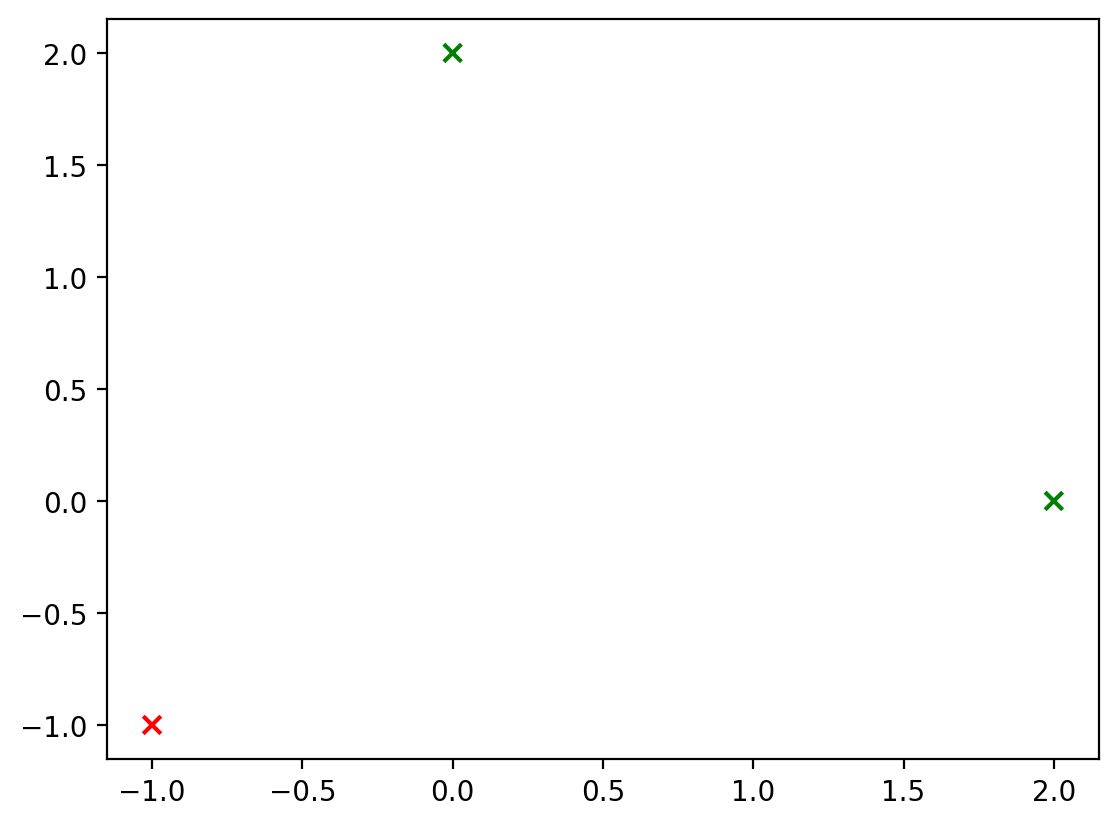

In [13]:
x = np.array([[0.0, 2.0], [2.0, 0.0], [-1.0, -1.0]])
t = np.array([1.0, 1.0, -1.0])

plt.scatter(x[:, 0], x[:, 1], s=40, c=[('g' if label == 1 else 'r') for label in t], marker="x")
plt.show()

In [15]:
model = SupportVectorClassifier(kernel=None, C=np.inf)
model.fit(x, t)

print(f"Found {model.n_support_vectors} support vectors.")

Found 3 support vectors.


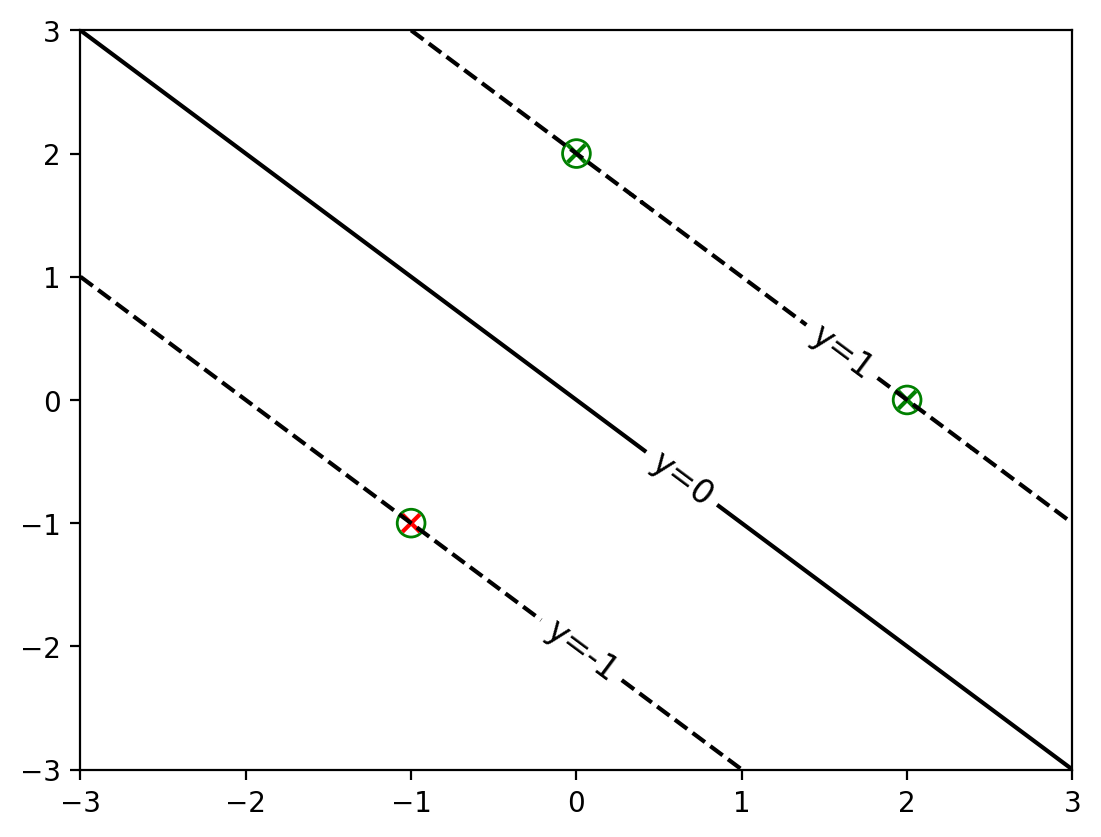

In [21]:
x0, x1 = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
xx = np.array([x0, x1]).reshape(2, -1).T

plt.scatter(x[:, 0], x[:, 1], s=40, c=[('g' if label == 1 else 'r') for label in t], marker="x")
plt.scatter(model.support_vectors[:, 0], model.support_vectors[:, 1], s=100, facecolor="none", edgecolor="g")
cp = plt.contour(
    x0,
    x1,
    model.predict(xx)[1].reshape(100, 100),
    np.array([-1, 0, 1]),
    colors="k",
    linestyles=("dashed", "solid", "dashed"),
)
plt.clabel(cp, fmt="y=%.f", inline=True, fontsize=12)
plt.show()

### 7.1.1 Overlapping class distributions

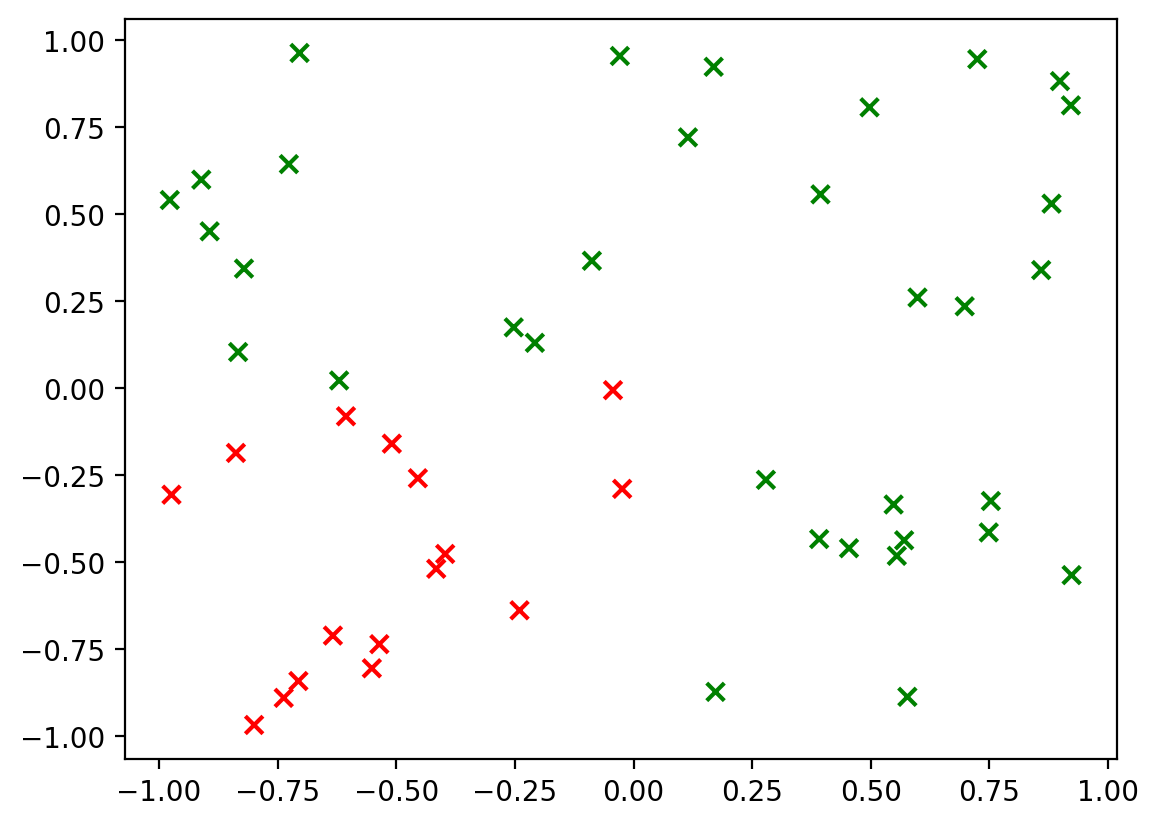

In [26]:
x = np.random.uniform(-1, 1, 100).reshape(-1, 2)
t = x < 0
t = (t[:, 0] * t[:, 1]).astype(float)
t = 1 - 2 * t
 
plt.scatter(x[:, 0], x[:, 1], s=40, c=[('g' if label == 1 else 'r') for label in t], marker="x")
plt.show()

In [27]:
model = SupportVectorClassifier(RBF(theta=np.ones(2)))
model.fit(x, t)

print(f"Found {model.n_support_vectors} support vectors.")

Found 21 support vectors.


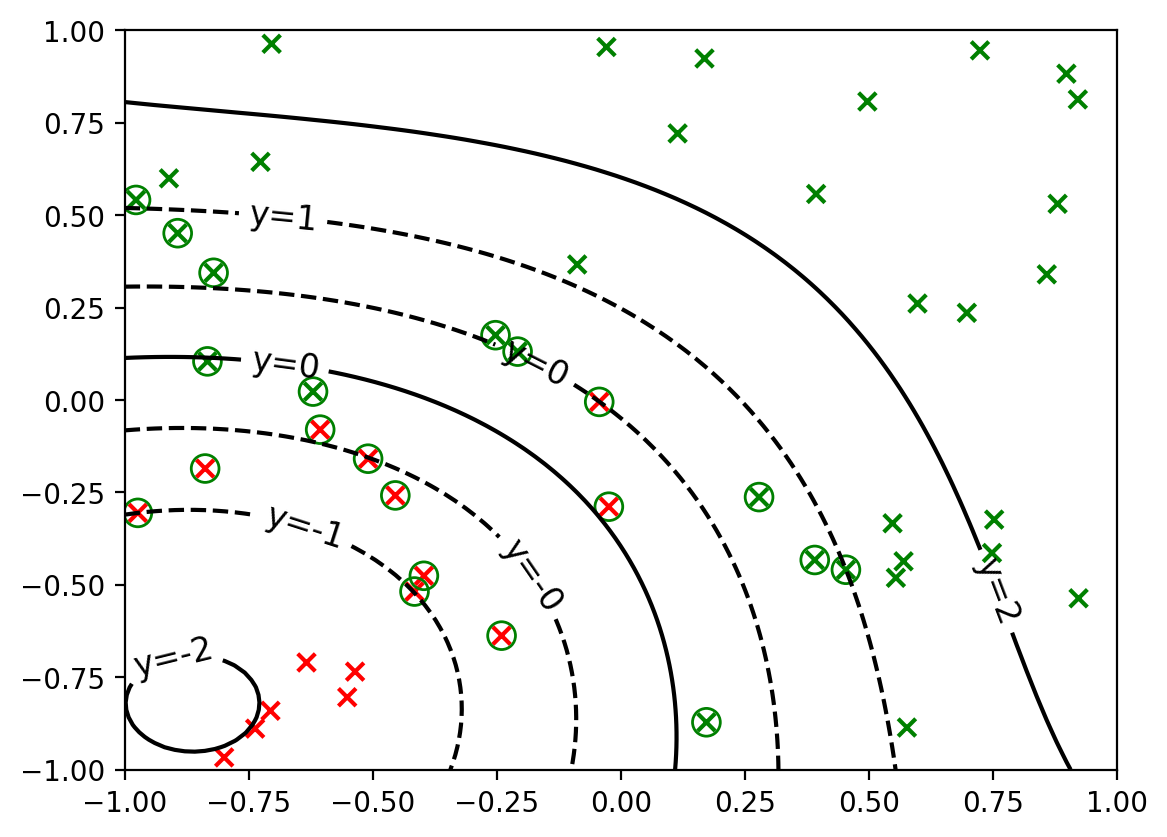

In [29]:
x0, x1 = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
xx = np.array([x0, x1]).reshape(2, -1).T

plt.scatter(x[:, 0], x[:, 1], s=40, c=[('g' if label == 1 else 'r') for label in t], marker="x")
plt.scatter(model.support_vectors[:, 0], model.support_vectors[:, 1], s=100, facecolor="none", edgecolor="g")
cp = plt.contour(x0, x1, model.predict(xx)[1].reshape(100, 100), colors="k", linestyles=("dashed", "solid", "dashed"))
plt.clabel(cp, fmt="y=%.f", inline=True, fontsize=12)
plt.show()